<a href="https://colab.research.google.com/github/natiska/ai4trees-height/blob/main/notebooks/Natalia/JDI_GC_prepare_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing annotations for the tiles made from Justdiggit Google Cloud data

In [3]:
#import matplotlib
#matplotlib.use('Agg')

In [15]:
import os
from osgeo import gdal
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
import numpy as np
import gdal
from matplotlib.path import Path

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  72485      0 --:--:-- --:--:-- --:--:-- 72485
OK
30 packages can be upgraded. Run 'apt list --upgradable' to see them.
gcsfuse is already the newest version (0.41.6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [4]:
!mkdir -p justdiggit-drone-data
!gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 justdiggit-drone justdiggit-drone-data

2022/09/06 21:30:19.370183 Start gcsfuse/0.41.6 (Go version go1.18.4) for app "" using mount point: /content/justdiggit-drone-data
2022/09/06 21:30:19.386406 Opening GCS connection...
2022/09/06 21:30:19.990324 Mounting file system "justdiggit-drone"...
2022/09/06 21:30:19.990908 File system has been successfully mounted.


In [5]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Defining paths and variables

In [6]:
annotations_file = '/content/justdiggit-drone-data/label_sample/Annotations_trees_only.json'
rgb_tiles_path = '/content/drive/MyDrive/AI4Trees/google_cloud_data/RGB_tiles_tif'
height_tiles_path = '/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/tiles_annotated'
# Save the masks as png files in the below specified path
output_path = '/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/masks'
# only images from 2019 have DSM data provided
year = 2019

In [7]:
annotations = json.load(open(annotations_file))

In [8]:
filename2id = {x['file_name'].split(".")[0]: x['id'] for x in annotations['images']}

# Testing on single file

## First approach: plotting mask with matplotlib and saving as png

In [9]:
def prepare_mask(tile_name, filename2id, tiles_path, annotations, add_bboxes=False, show_image_in_background=False):
  id = filename2id[tile_name]
  tile_name_elements = tile_name.split("_")
  village = tile_name_elements[0]
  year = tile_name_elements[2]
  img_path = os.path.join(tiles_path, village, year, tile_name+".tiff")
  print(img_path)
  img_array = gdal.Open(img_path).ReadAsArray()
  if len(list(img_array.shape)) == 3:
    img_array = np.swapaxes(np.swapaxes(img_array,0,2),0,1)
  fig = plt.figure(frameon=False)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  if show_image_in_background:
    ax.imshow(img_array)
    mask_color = 'r'
    opacity = 0.5
  else:
    mask_color = 'b'
    opacity = 1.0
    ax.set_facecolor('#000000')
    plt.gca().invert_yaxis()

  for i,annot in enumerate(annotations['annotations']):
    if annot['image_id'] == id:
      # put mask on the image
      segmentation = annotations['annotations'][i]['segmentation']
      for seg in segmentation:
        if img_array.shape[0] == 250:
          x_list = np.array(seg[0::2])/4
          y_list = np.array(seg[1::2])/4
        elif img_array.shape[0] == 1000:
          x_list = np.array(seg[0::2])
          y_list = np.array(seg[1::2])
        else:
          raise ValueError(f"Image dimensions of {img_array.shape} not expected")
        ax.fill(x_list, y_list, alpha=opacity, fc=mask_color, ec='none')
      #create the rectangle object and add it to the image
      if add_bboxes:
        bbox = annot['bbox']
        x1, y1, width, height = bbox
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        ax.add_patch(rect)
  fig.tight_layout(pad=0)
  plt.savefig(f"{tile_name}.png", bbox_inches='tight', padding=0)
  plt.show()
  return fig

/content/drive/MyDrive/AI4Trees/google_cloud_data/RGB_tiles_tif/bumila/2019/bumila_year_2019_tile_8000_14000.tiff


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


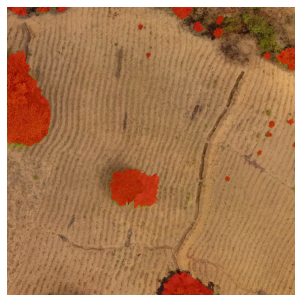

In [10]:
fig1 = prepare_mask("bumila_year_2019_tile_8000_14000", filename2id, rgb_tiles_path, annotations, show_image_in_background=True)

/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/tiles_annotated/bumila/2019/bumila_year_2019_tile_8000_14000.tiff


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


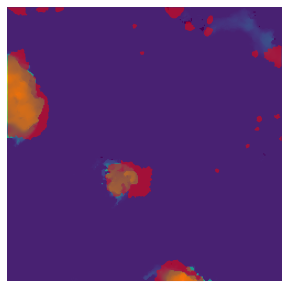

In [16]:
fig2 = prepare_mask("bumila_year_2019_tile_8000_14000", filename2id, height_tiles_path, annotations, show_image_in_background=True)

/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/tiles_annotated/bumila/2019/bumila_year_2019_tile_8000_14000.tiff


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


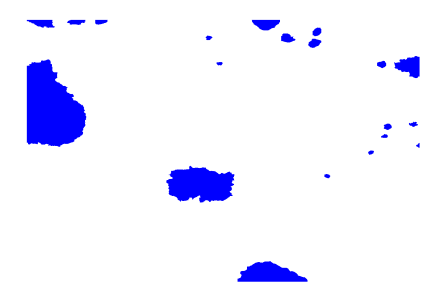

In [12]:
pure_mask = prepare_mask("bumila_year_2019_tile_8000_14000", filename2id, height_tiles_path, annotations, show_image_in_background=False)

In [17]:
pure_mask.canvas.get_width_height()

(432, 288)

In [18]:
import imageio

im = imageio.imread('bumila_year_2019_tile_8000_14000.png')
print(im.shape)

(302, 302, 4)


Dropping this approach because I can't get to the desired format of the output. The generated file is of a different size than expected.

## Second attempt: creating a numpy array

This attempt only resulted in the mask outlines, but I'm keeping it for the record.

In [44]:
def create_mask_outlines(tile_name, tiles_path, filename2id, annotations):
  id = filename2id[tile_name]
  tile_name_elements = tile_name.split("_")
  village = tile_name_elements[0]
  year = tile_name_elements[2]
  img_path = os.path.join(tiles_path, village, year, tile_name+".tiff")
  print(img_path)
  img_array = gdal.Open(img_path).ReadAsArray()
  if len(list(img_array.shape)) == 3:
    img_array = img_array[0]
  mask_array = np.zeros(img_array.shape)
  for i,annot in enumerate(annotations['annotations']):
    if annot['image_id'] == id:
      # put mask on the image
      segmentation = annotations['annotations'][i]['segmentation']
      for seg in segmentation:
        if img_array.shape[0] == 250:
          x_list = np.array(seg[0::2])/4
          y_list = np.array(seg[1::2])/4
        elif img_array.shape[0] == 1000:
          x_list = np.array(seg[0::2])
          y_list = np.array(seg[1::2])
        else:
          raise ValueError(f"Image dimensions of {img_array.shape} not expected")
        for i in range(len(x_list)):
          mask_array[x_list[i], y_list[i]] = 1
  return mask_array

In [45]:
mask_outlines = create_mask_outlines("bumila_year_2019_tile_8000_14000", rgb_tiles_path, filename2id, annotations)

/content/drive/MyDrive/AI4Trees/google_cloud_data/RGB_tiles_tif/bumila/2019/bumila_year_2019_tile_8000_14000.tiff


In [46]:
mask_outlines.shape

(1000, 1000)

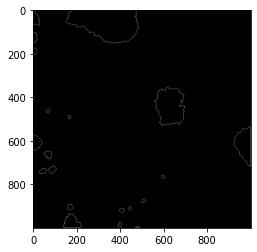

In [47]:
plt.imshow(mask_outlines, cmap='gray')
plt.show()

## Third attempt: creating a numpy array with filled polygons

Success!

In [80]:
def create_mask_array(tile_name, tiles_path, filename2id, annotations):
  id = filename2id[tile_name]
  tile_name_elements = tile_name.split("_")
  village = tile_name_elements[0]
  year = tile_name_elements[2]
  img_path = os.path.join(tiles_path, village, year, tile_name+".tiff")
  #print(img_path)
  img_array = gdal.Open(img_path).ReadAsArray()
  if len(list(img_array.shape)) == 3:
    img_array = img_array[0]
  mask_array = np.zeros(img_array.shape)
  nr, nc = img_array.shape
  for i,annot in enumerate(annotations['annotations']):
    if annot['image_id'] == id:
      # put mask on the image
      segmentation = annotations['annotations'][i]['segmentation']
      for seg in segmentation:
        if img_array.shape[0] == 250:
          x_list = np.array(seg[0::2])/4
          y_list = np.array(seg[1::2])/4
        elif img_array.shape[0] == 1000:
          x_list = np.array(seg[0::2])
          y_list = np.array(seg[1::2])
        else:
          raise ValueError(f"Image dimensions of {img_array.shape} not expected")
        xycrop = np.vstack((x_list, y_list)).T
        ygrid, xgrid = np.mgrid[:nr, :nc]
        xypix = np.vstack((xgrid.ravel(), ygrid.ravel())).T
        # construct a Path from the vertices
        pth = Path(xycrop, closed=False)
        # test which pixels fall  within the path
        mask = pth.contains_points(xypix)
        # reshape to the same size as the image
        mask = mask.reshape(img_array.shape)
        mask_array = np.logical_or(mask_array, mask)
  return mask_array

In [83]:
mask_array = create_mask_array("bumila_year_2019_tile_8000_14000", height_tiles_path, filename2id, annotations)

In [84]:
mask_array.shape

(250, 250)

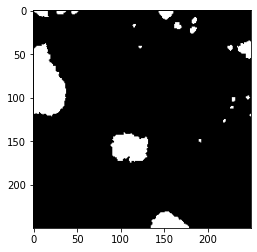

In [85]:
plt.imshow(mask_array, cmap='gray')
plt.show()

In [86]:
imageio.imwrite('mask.png', mask_array.astype('uint8'))

In [87]:
saved_mask = imageio.imread('mask.png')
print(saved_mask.shape)

(250, 250)


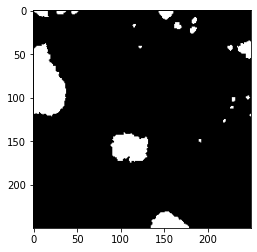

In [88]:
plt.imshow(saved_mask, cmap='gray')
plt.show()

# Performing this task on all tiles

In [56]:
import glob

In [89]:
i = 0
for village in os.listdir(height_tiles_path):
  output_folder = os.path.join(output_path, village, '2019')
  print(output_folder)
  if os.path.exists(output_folder) == False:
    os.makedirs(output_folder)
  for path in glob.glob(os.path.join(height_tiles_path, village, '2019', "*.tiff")):
    #print(path)
    path_elements = path.split("/")
    tile_name = path_elements[-1].replace(".tiff", "")
    mask_array = create_mask_array(tile_name, height_tiles_path, filename2id, annotations)
    imageio.imwrite(os.path.join(output_folder, f'{tile_name}.png'), mask_array.astype('uint8'))
    i += 1
  print(f"Saved {i} masks in {output_folder}.")
  i = 0

/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/masks/chaludewa/2019
Saved 84 masks in /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/masks/chaludewa/2019.
/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/masks/bumila/2019
Saved 89 masks in /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/masks/bumila/2019.
/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/masks/ikengwa/2019
Saved 74 masks in /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/masks/ikengwa/2019.
/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/masks/kisima/2019
Saved 80 masks in /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/masks/kisima/2019.
/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/masks/loo/2019
Saved 47 masks in /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/masks/loo

In [91]:
num_all_masks = len(glob.glob(f"{output_path}/*/*/*.png"))
num_all_masks

388

In [93]:
num_all_inputs = len(glob.glob(f"{height_tiles_path}/*/*/*.tiff"))
num_all_inputs

388